# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Ratings

In [2]:
df = pd.read_csv(r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\ratings\s243933_image_ratings.csv")

In [3]:
images_list = df['Image'].tolist()
ratings = df['Rating'].tolist()
norm_ratings = [(x - min(ratings)) / (max(ratings) - min(ratings)) for x in ratings]

In [4]:
len(norm_ratings)

545

In [5]:
range(math.floor(min(norm_ratings)), math.ceil(max(norm_ratings) + 2))

range(0, 3)

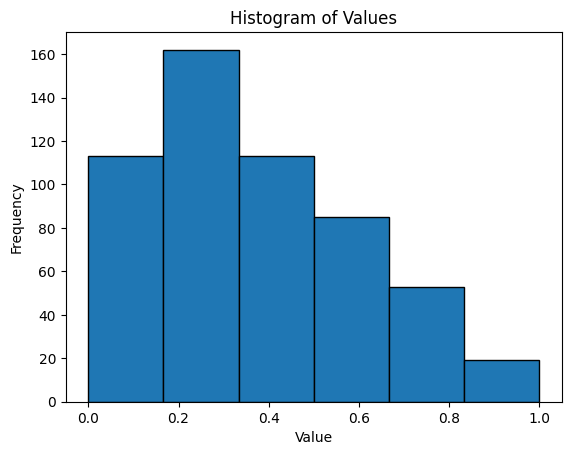

In [6]:
plt.hist(norm_ratings, 6, edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Values")
plt.show()

# Data Matrix

In [7]:
# Load images
image_folder = r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\preprocessed_data"

Due to images being shown twice during rating, images must be duplicated in the data matrix as well, and they must also be ordered!

In [8]:
# Init matrix J
J = np.array([]).reshape(0, 100*100)  # Assuming images are 64x64 pixels

In [ ]:
# Add each image that is rated to matrix J -> each row is a flattened image
for img_file in images_list:
    img = Image.open(os.path.join(image_folder, img_file))
    img_array = np.array(img).flatten()
    J = np.vstack([J, img_array])

In [10]:
J.shape

(545, 10000)

In [11]:
# Get the mean image and center the data
mean_J = np.mean(J, axis=0)
J_centered = J - mean_J
J_centered

array([[-37.96513761, -34.4587156 , -29.91192661, ..., -50.90825688,
        -58.45688073, -62.88440367],
       [ 15.03486239,  28.5412844 ,  27.08807339, ...,  -0.90825688,
         -6.45688073, -10.88440367],
       [ 74.03486239,  63.5412844 ,  61.08807339, ...,  37.09174312,
         20.54311927,  29.11559633],
       ...,
       [-48.96513761, -29.4587156 , -48.91192661, ..., -60.90825688,
        -57.45688073, -55.88440367],
       [-75.96513761, -72.4587156 , -79.91192661, ...,  64.09174312,
         67.54311927,  71.11559633],
       [ 20.03486239,  18.5412844 ,  33.08807339, ...,  57.09174312,
         57.54311927,  58.11559633]])

# PCA

In [ ]:
# Do PCA on the centered data (all possible components = min(n_samples, n_features))
pca = PCA(n_components=545)
scores = pca.fit_transform(J_centered)
components = pca.components_

Text(0, 0.5, 'Cumulative Explained Variance')

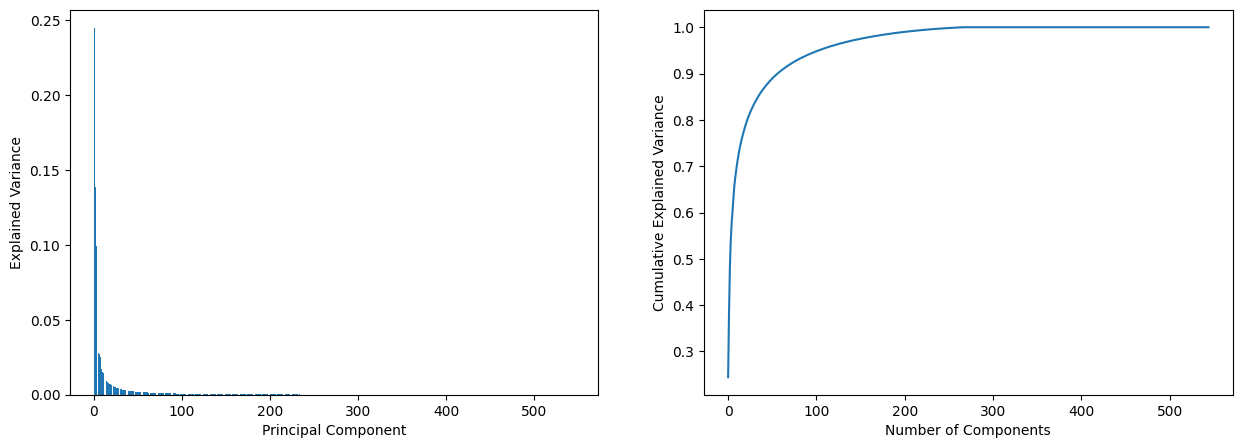

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot explained variance
ax[0].bar(range(1, 546), pca.explained_variance_ratio_)
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Explained Variance')

# Plot cumulative explained variance
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')

In [21]:
# Select number of components to explain approx. 90% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f'Number of components to explain ~95% variance: {n_components_95}')

actual_pca = PCA(n_components=n_components_95)
actual_scores = actual_pca.fit_transform(J_centered)
actual_components = actual_pca.components_

Number of components to explain ~95% variance: 104


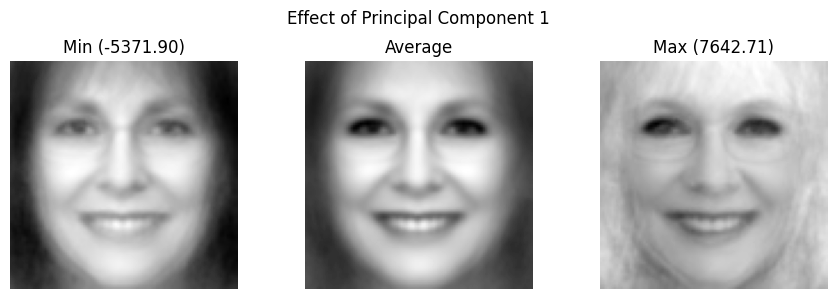

In [22]:
# For PC1, visualize variation
min_score = np.min(actual_scores[:, 0])
max_score = np.max(actual_scores[:, 0])

# Three images: min, mean, max
# Image components weighted by min/max scores added onto the average image shows the effect of that component
img_min = (mean_J + min_score * actual_components[0]).reshape(100, 100)
img_avg = mean_J.reshape(100, 100)
img_max = (mean_J + max_score * actual_components[0]).reshape(100, 100)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

titles = [f"Min ({min_score:.2f})", "Average", f"Max ({max_score:.2f})"]
imgs = [img_min, img_avg, img_max]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.suptitle(f"Effect of Principal Component 1")
plt.tight_layout()
plt.show()

# Linear Regression (w/ Feature Selection)

In [23]:
lin_reg = LinearRegression()
selector = SequentialFeatureSelector(lin_reg)
selector = selector.fit(actual_scores, norm_ratings)

In [29]:
selected_features = selector.get_support()
selected_indices = np.where(selected_features)[0]
print(f"Number of selected PCs: {len(selected_indices)} out of {n_components_95}\nSelected PCs: {selected_indices}")

Number of selected PCs: 52 out of 104
Selected PCs: [  1   2   3   4   6   7   9  10  14  15  17  21  22  23  26  27  28  29
  30  32  33  34  35  37  41  42  45  46  49  50  51  53  55  58  60  61
  62  65  68  70  73  75  77  81  83  84  87  88  93 100 101 103]


# Generate Syntentic Images

In [ ]:
# Genereate images
# One for each of the five rating labels (0, 0.25, 0.5, 0.75, 1)
rating_labels = [0, 0.25, 0.5, 0.75, 1]


